# Prediction using causal inference for variable selection


In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     

import xarray as xr
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
from tigramite.models import Prediction

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'torch'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/models.py:29: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versions.

## 1. Structural causal processes with contemporaneous and lagged dependencies



## Analysis Parameters


<!-- CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc -->

<!-- Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Daily.nc

'AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc'

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

'Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc'

/Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc

Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Daily.nc

DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Monthly.nc 

In [9]:
site = 'Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc'
var = ['GPP_SOLO', 'Ta', 'VPD','Precip', 'Fsd']
var_names = ['GPP','Ta', 'VPD', 'precip', 'solar']
target = 0 #GPP
tau_max = 1
steps_ahead = 1

## Load data

In [10]:
def VPD(rh, ta):
    sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd

ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+site)
# ds = ds.sel(time=slice(time[0], time[1]))
ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  #Set negative GPP, ER, and ET measurements as zero
ds['VPD'] = VPD(ds.RH, ds.Ta)

ds_clim_mean = ds.groupby('time.month').mean()
ds = (ds.groupby('time.month') - ds_clim_mean)

df = ds.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1)

# calculate VPD on ec data
#df['VPD'] = VPD(df.RH, df.Ta)
df = df[var].dropna()
# test = df[-6:]
# df = df[0:-6]

data = df.values
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

# # Initialize dataframe object, specify time axis and variable names
# test_dataframe = pp.DataFrame(test.values, 
#                          datatime = {0:np.arange(len(test.values))}, 
#                          var_names=var_names)

## Prediction

Tigramite also contains a class tigramite.models.Prediction to perform predictions based on the sklearn models. The Prediction class includes a wrapper around run_pc_stable from the PCMCI class to perform predictor selection

We initialize the Prediction class with cond_ind_model=ParCorr(). Secondly, we choose sklearn.linear_model.LinearRegression() here for prediction. Last, we scale the data via data_transform. The class takes care of rescaling the data for prediction. The parameters train_indices and test_indices are used to divide the data up into a training set and test set. The test set is optional since new data can be supplied later. The training set is used to select predictors and fit the model.

(<Figure size 1080x360 with 5 Axes>,
 array([<AxesSubplot:ylabel='GPP'>, <AxesSubplot:ylabel='Ta'>,
        <AxesSubplot:ylabel='VPD'>, <AxesSubplot:ylabel='precip'>,
        <AxesSubplot:xlabel='time', ylabel='solar'>], dtype=object))

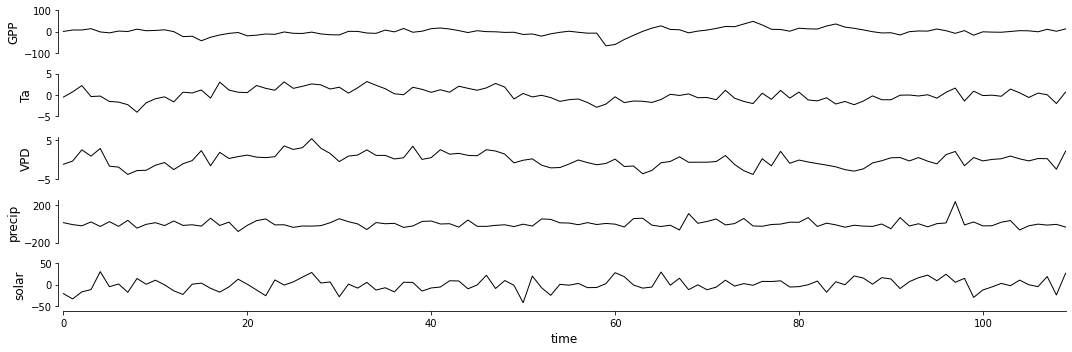

In [11]:
tp.plot_timeseries(dataframe, figsize=(15, 5))

In [12]:
pred = Prediction(dataframe=dataframe,
        cond_ind_test=ParCorr(), 
        prediction_model = RandomForestRegressor(),
        # data_transform=sklearn.preprocessing.StandardScaler(),
        train_indices= range(int(0.8*T)),
        test_indices= range(int(0.8*T), T),
        verbosity=1
    )


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 1: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 2: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 3: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 4: []}
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable GPP has 2 link(s):
    [pc_alpha = 0.2]
        (GPP -1): max_pval = 0.00000, min_val =  0.744
        (precip -1): max_pval = 0.11796, min_val =  0.151

    Variable Ta has 2 link(s):
    [pc_alpha = 0.2]
        (Ta -1): max_pval = 0.00036, min_val =  0.339
        (precip -1): max_pval = 0.15690, min_val = -0.137

    Variable VPD has 3 link(s):
 

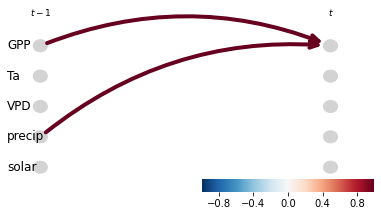

In [13]:
# Make solar have no parents
selected_links = {}

for j in range(N):
    if j in list(range(N-1)):
        selected_links[j] = [(var, -lag) for var in range(N)
                         for lag in range(0, tau_max + 1)]
    else:
        selected_links[j] = []

predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=None,
                  selected_links=selected_links
                  )

graph = np.zeros((N, N, tau_max+1), dtype='bool')

for j in [target]:
    for p in predictors[j]:
        graph[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
#     node_aspect=2.,
    val_matrix=np.ones(graph.shape),
    graph=graph,
    var_names=var_names,
    link_colorbar_label='',
    );

In [14]:
pred.fit(target_predictors=predictors, 
         selected_targets=[target],
         tau_max=tau_max
        )


##
## Predicting target 0
##


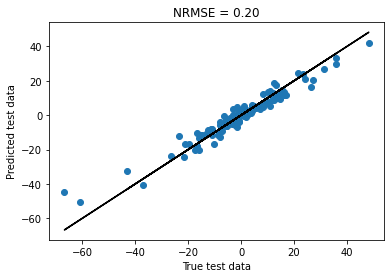

In [15]:
predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()